# A guided tour through the neighborhood
This notebook gives an overview about quantitative neighborhood measurement / visualization functions in clesperanto.

In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread
import pandas as pd
import numpy as np
import stackview

We select an NVidida (GTX or RTX) GPU if available.

In [2]:
cle.select_device('TX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

Some of the functions we're using here are quite new in clesperanto. Thus, we print out the libraries' version.

In [3]:
cle.__version__

'0.23.3'

## Example data
We start with the blobs example image from ImageJ. In our version it shows bright blobs that can be segmented using [Voronoi-Otsu-Labeling](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html).

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
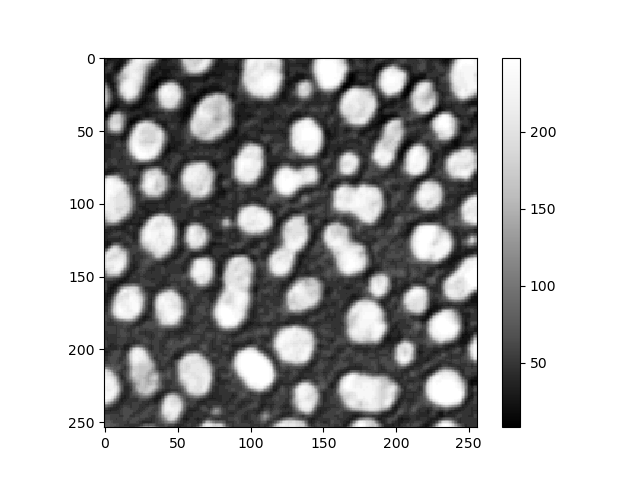
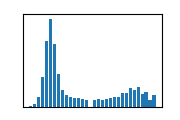

In [4]:
raw = imread("../../data/blobs.tif")
blobs = stackview.insight(raw)
blobs

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
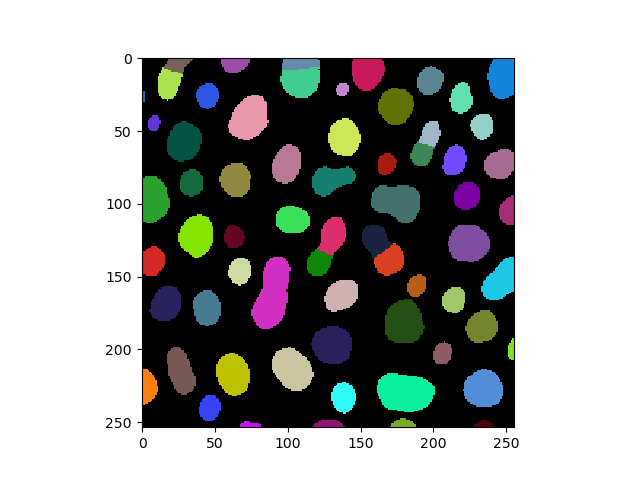

In [5]:
labels = cle.voronoi_otsu_labeling(blobs, spot_sigma=3.5)
labels

## Neighborhood definitions
We differentiate three kinds of neighborhoods. 

### Touching neighbors
To demonstrate touching neighborhoods, we increase the size of our labeled objects a bit first.

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
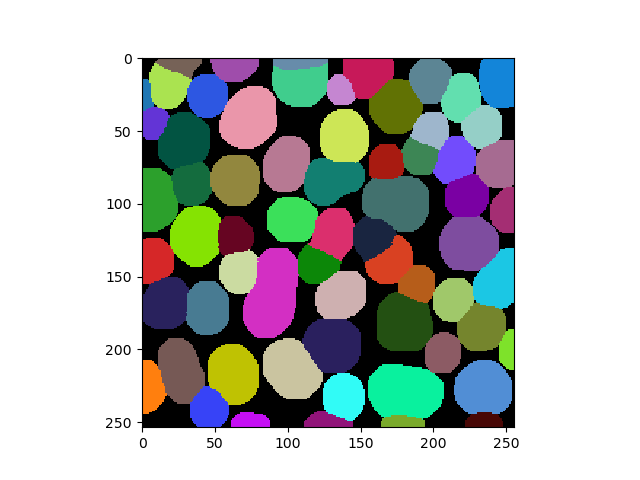

In [6]:
larger_labels = cle.dilate_labels(labels, radius=6)
larger_labels

## We can then connect the centroids of touching objects.

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
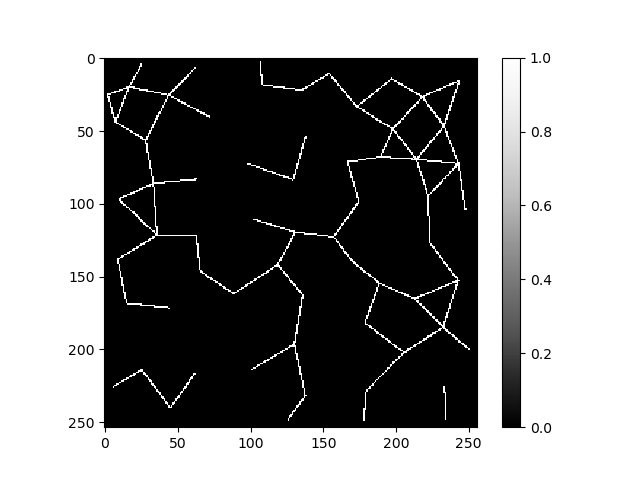
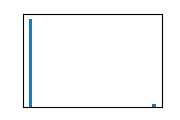

In [7]:
touching_mesh = cle.draw_mesh_between_touching_labels(larger_labels)
touching_mesh

clesperanto's `imshow` function allows to overlay both images.

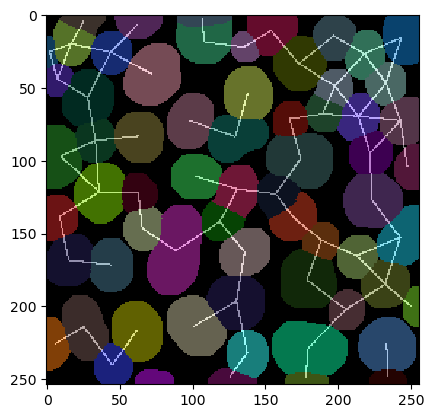

In [8]:
cle.imshow(larger_labels, labels=True, continue_drawing=True)
cle.imshow(touching_mesh, alpha=0.5)

### n-nearest neighbors

Also the n-nearest neighbors are drived from the distances between centroids. When interpreting the resulting neighbor-mesh, it is possible that a n=2-neighbor mesh contains objects that have connections to more than 2 neighbors. The unterlying reason is that the other object might connect to them.

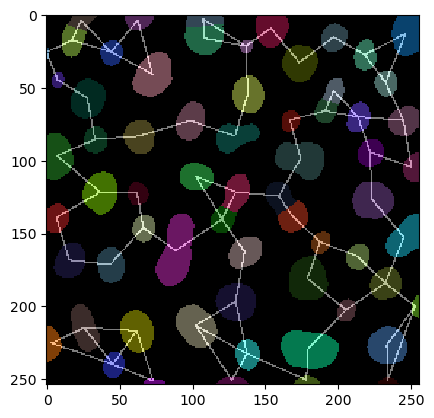

In [9]:
n = 2

n_nearest_neighbors_mesh = cle.draw_mesh_between_n_closest_labels(labels, n=n)

cle.imshow(labels, labels=True, continue_drawing=True)
cle.imshow(n_nearest_neighbors_mesh, alpha=0.5)

Note that this neighborhoood-representation is centroid-based. Collaborators have asked for distances between edges of objects. This is hard to compute on graphics cards, because it is tricky to paralellize.

### Proximal neighbors
Proximal neighbors are neighbors which have a centroid distance below a given threshold

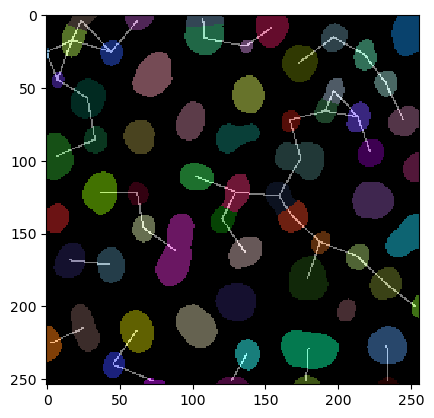

In [10]:
distance_threshold = 30

proximal_neighbors_mesh1 = cle.draw_mesh_between_proximal_labels(labels, maximum_distance=distance_threshold)

cle.imshow(labels, labels=True, continue_drawing=True)
cle.imshow(proximal_neighbors_mesh1, alpha=0.5)

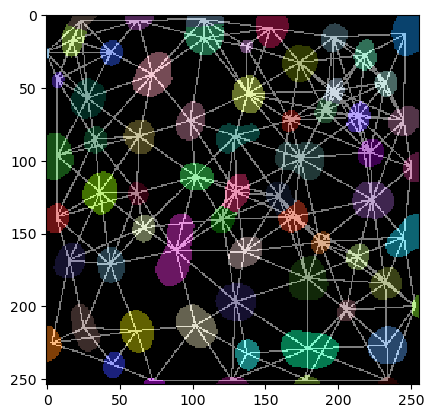

In [11]:
distance_threshold = 60

proximal_neighbors_mesh2 = cle.draw_mesh_between_proximal_labels(labels, maximum_distance=distance_threshold)

cle.imshow(labels, labels=True, continue_drawing=True)
cle.imshow(proximal_neighbors_mesh2, alpha=0.5)

## Under the hood: Adjacency graphs matrices
Under the hood, these functions are based on [neighbor-adjacency-graph-matrices](https://en.wikipedia.org/wiki/Adjacency_matrix) which have the labels 0...n on the X- and the Y-axis. Label 0 corresponds to background. For example, the touching-mesh is represented by the touch matrix. In this matrix, the first row and colum are mostly white because all labels touch the background.

cl.OCLArray([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)
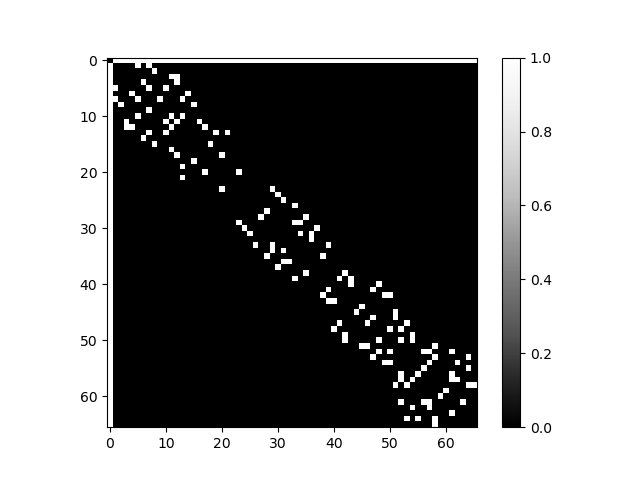
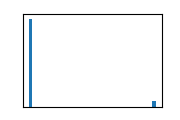

In [12]:
touch_matrix = cle.generate_touch_matrix(larger_labels)
touch_matrix

This matrix can be represented as mesh, identical with the one shown above.

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
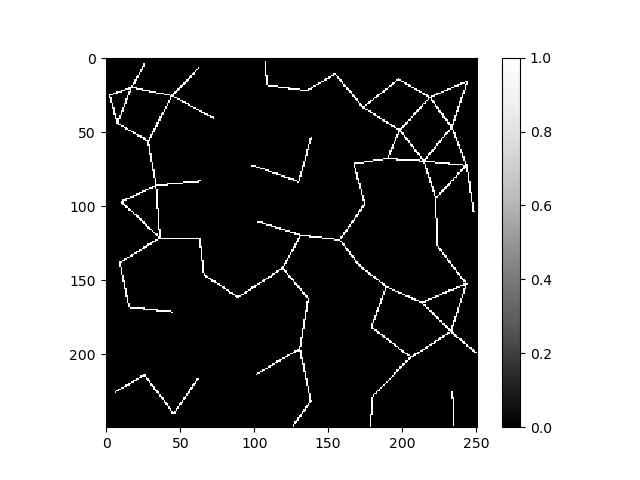
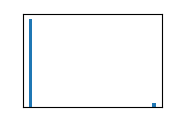

In [13]:
centroids = cle.centroids_of_labels(larger_labels)

touching_mesh2 = cle.touch_matrix_to_mesh(centroids, touch_matrix)
touching_mesh2

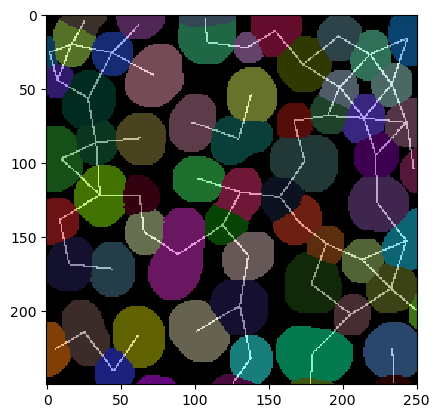

In [14]:
cle.imshow(larger_labels, labels=True, continue_drawing=True)
cle.imshow(touching_mesh2, alpha=0.5)

## Neighbors of neighbors
We can also compute which neighbors can reach other neighbors via one neighbor. Before we can do that, we need to remove the touches with backgrounnd. 

Note: This is one of the rare functions in clesperanto which modifies the input.

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
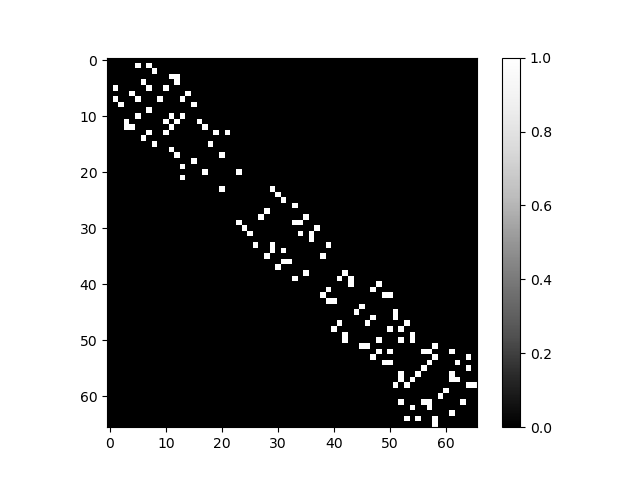
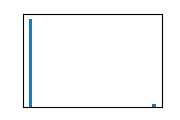

In [15]:
cle.set_column(touch_matrix, 0, 0)
cle.set_row(touch_matrix, 0, 0)
touch_matrix

cl.OCLArray([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]], dtype=float32)
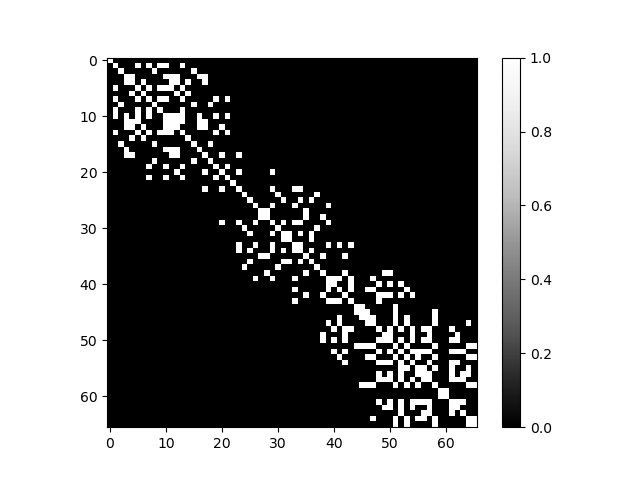
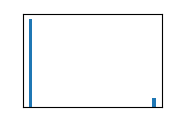

In [16]:
touching_neighbors_of_touching_neighbors_matrix = cle.neighbors_of_neighbors(touch_matrix)
touching_neighbors_of_touching_neighbors_matrix

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
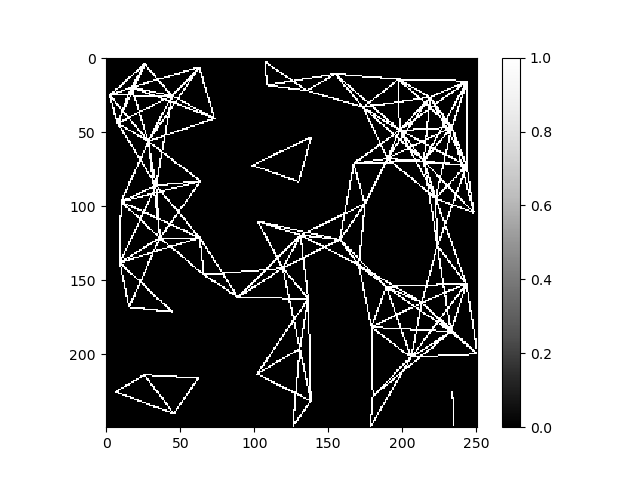
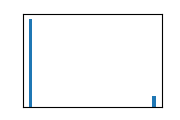

In [17]:
neighbor_of_neighbor_mesh = cle.touch_matrix_to_mesh(centroids, touching_neighbors_of_touching_neighbors_matrix)
neighbor_of_neighbor_mesh

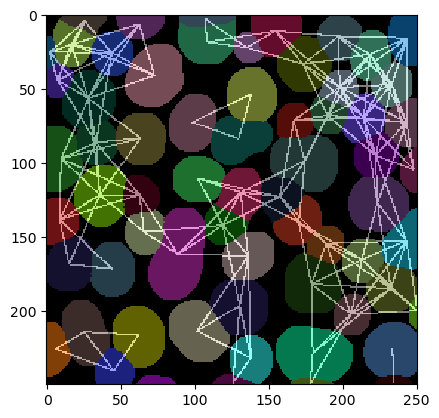

In [18]:
cle.imshow(larger_labels, labels=True, continue_drawing=True)
cle.imshow(neighbor_of_neighbor_mesh, alpha=0.5)

In [19]:
def fun_with_neighbors(labels, iterations:int = 0):
    
    centroids = cle.centroids_of_labels(labels)
    
    # determine which labels touch
    touch_matrix = cle.generate_touch_matrix(labels)
    
    # eliminate connections to background
    cle.set_column(touch_matrix, 0, 0)
    cle.set_row(touch_matrix, 0, 0)
    
    # derived neighbors of neighbors of neighbors of neighbors of neighbors of neighbors of neighbors of neighbors 
    for i in range(iterations):
        touch_matrix = cle.neighbors_of_neighbors(touch_matrix)
    
    # draw the mesh
    mesh = cle.touch_matrix_to_mesh(centroids, touch_matrix)

    # combine labels and mesh
    return (labels * (mesh == 0)).astype(np.uint32)

stackview.interact(fun_with_neighbors, larger_labels, continuous_update=True)

## Basic neighborhood quantification
The meshes shown above are quite informative visually. If one wanted to quantify these visual representations, one could for example count the number of neighbors within a given radius.

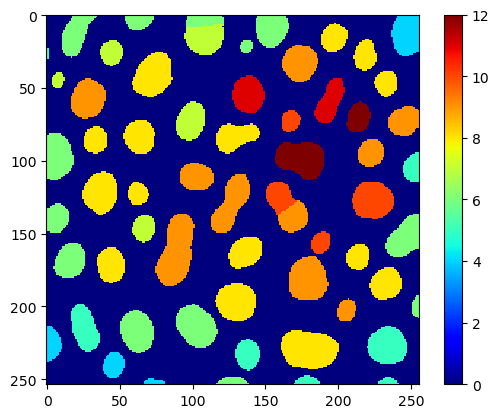

In [20]:
proximal_neighbor_count_map = cle.proximal_neighbor_count_map(labels, max_distance=distance_threshold)

cle.imshow(proximal_neighbor_count_map, colorbar=True, colormap='jet')

The same information can also be derived in tabular form.

In [21]:
stats = cle.statistics_of_labelled_neighbors(labels, nearest_neighbor_ns=[2], 
                                     proximal_distances=[distance_threshold], 
                                     dilation_radii=[])
                                 
pd.DataFrame(stats).T                          

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
label,1.000000,2.000000e+00,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,5.600000e+01,57.000000,58.000000,59.000000,60.000000,61.000000,62.000000,63.000000,6.400000e+01,65.000000
touching_neighbor_count,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
minimum_distance_of_touching_neighbors,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,14.950460,0.000000,14.950460,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
average_distance_of_touching_neighbors,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,14.950460,0.000000,14.950460,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
maximum_distance_of_touching_neighbors,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,14.950460,0.000000,14.950460,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
max_min_distance_ratio_of_touching_neighbors,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proximal_neighbor_count_d60,5.000000,4.000000e+00,6.000000,6.000000,7.000000,6.000000,6.000000,5.000000,6.000000,9.000000,...,9.000000e+00,8.000000,8.000000,5.000000,5.000000,9.000000,4.000000,5.000000,6.000000e+00,6.000000
maximum_distance_of_n2_nearest_neighbors,20.203375,4.452560e+01,38.343487,34.748077,24.151676,30.553041,19.406076,32.208775,29.987141,28.755064,...,3.009663e+01,28.760021,26.604811,32.926960,54.306267,31.390377,36.260948,32.584534,3.404361e+01,32.926960
average_distance_of_n2_nearest_neighbors,19.804726,3.452631e+01,33.232586,32.650558,22.177525,29.384724,17.178268,28.367903,22.468800,26.453369,...,2.791130e+01,26.357201,26.241840,28.587425,39.277077,30.075199,33.931465,31.340582,3.384203e+01,29.402916
distance_to_most_distant_other,324.783356,3.226502e+02,273.961212,270.941193,306.516571,278.148499,318.501892,299.073395,324.567871,282.806946,...,2.547971e+02,290.674438,281.354248,308.161285,324.783356,285.757263,322.650208,274.793823,2.760331e+02,307.186584


## Quantitative meshes
There are also visual forms of representing measurements on neighborhood graphs.

### Distance meshes
In this distance meshes the value/'color' along the mesh lines represents a quantiative measurement.

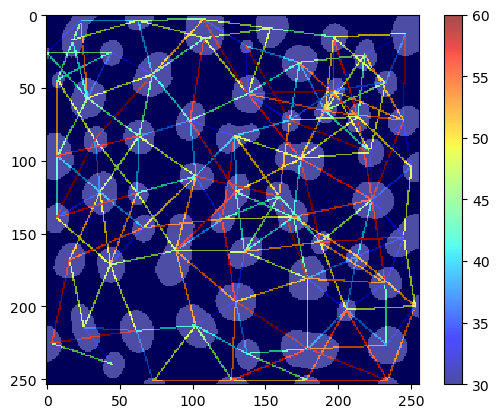

In [22]:
distance_mesh = cle.draw_distance_mesh_between_proximal_labels(labels, maximum_distance=distance_threshold)

cle.imshow(labels > 0, continue_drawing=True)
cle.imshow(distance_mesh, alpha=0.7, min_display_intensity=30, max_display_intensity=distance_threshold, colormap='jet', colorbar=True)

### Meshes representing the intensity along edges
We can also summarize the intensity along edges. The following code block might become a clesperanto-function at some point as well ([see also](https://github.com/clEsperanto/pyclesperanto_prototype/issues/286)). 

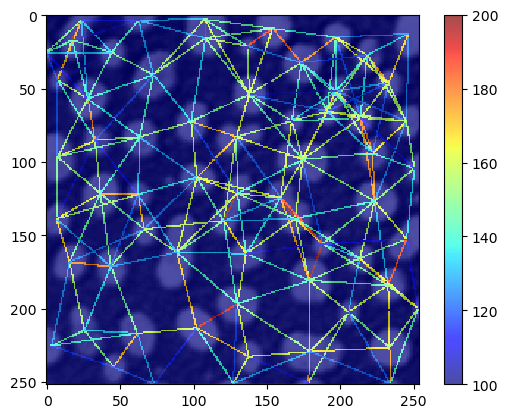

In [23]:
# Determine thresholds
centroids = cle.centroids_of_labels(labels)

# Make a centroid-to-centoird distance matrix
distance_matrix = cle.generate_distance_matrix(centroids, centroids)

# Threshold the distance matrix to make a binary matrix
proximal_neighbor_matrix = cle.generate_proximal_neighbors_matrix(distance_matrix, max_distance=distance_threshold)

# Determine intensity along the edges
mean_intensity_matrix = cle.generate_mean_intensity_between_points_matrix(blobs, centroids, proximal_neighbor_matrix, num_samples=10)

# draw the intensity mesh
mean_intensity_mesh = cle.touch_matrix_to_mesh(centroids, mean_intensity_matrix)

cle.imshow(blobs, continue_drawing=True)
cle.imshow(mean_intensity_mesh, alpha=0.7, min_display_intensity=100, max_display_intensity=200, colormap='jet', colorbar=True)

The same can be done using the standard deviation of the intensity along the lines.

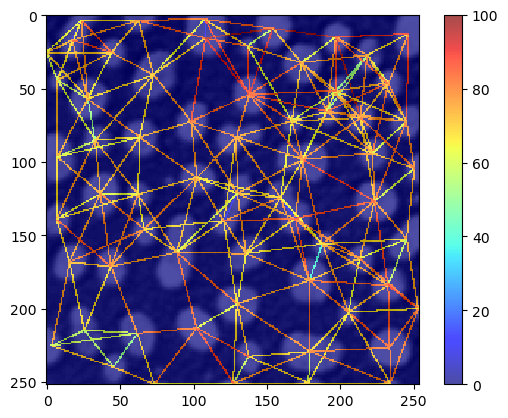

In [24]:
# Determine intensity along the edges
stddev_intensity_matrix = cle.generate_standard_deviation_intensity_between_points_matrix(blobs, centroids, proximal_neighbor_matrix, num_samples=10)

# draw the intensity mesh
stddev_intensity_mesh = cle.touch_matrix_to_mesh(centroids, stddev_intensity_matrix)

cle.imshow(blobs, continue_drawing=True)
cle.imshow(stddev_intensity_mesh, alpha=0.7, min_display_intensity=0, max_display_intensity=100, colormap='jet', colorbar=True)

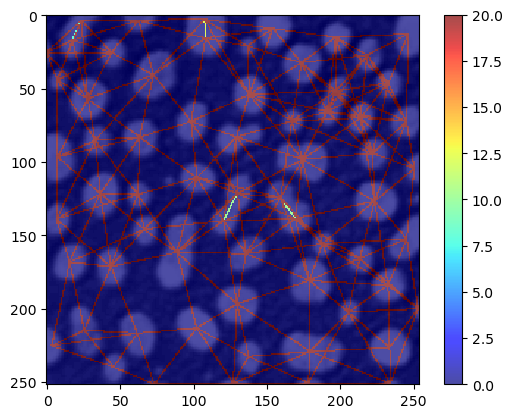

In [25]:
cle.imshow(blobs, continue_drawing=True)
cle.imshow(stddev_intensity_mesh, alpha=0.7, min_display_intensity=0, max_display_intensity=20, colormap='jet', colorbar=True)

## Using neighbor graph matrices for modifying label images
In the mesh shown above, there are some edges obviously different from others. The edges which connect centroids that lie both within the same objects have a much lower standard deviation intensity. We can exploit this to merge labels. Just as a reminder we look at the label image again.

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
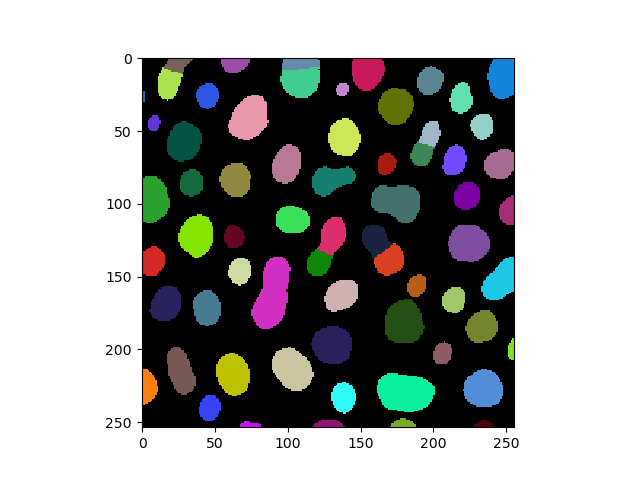

In [26]:
labels

Furthermore, we can view the `standard-deviation intensity along edges matrix` introduced above.

cl.OCLArray([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      , 73.99891 ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 73.99891 ,  0.      ,
        74.020546],
       [ 0.      ,  0.      ,  0.      , ...,  0.      , 74.020546,
         0.      ]], dtype=float32)
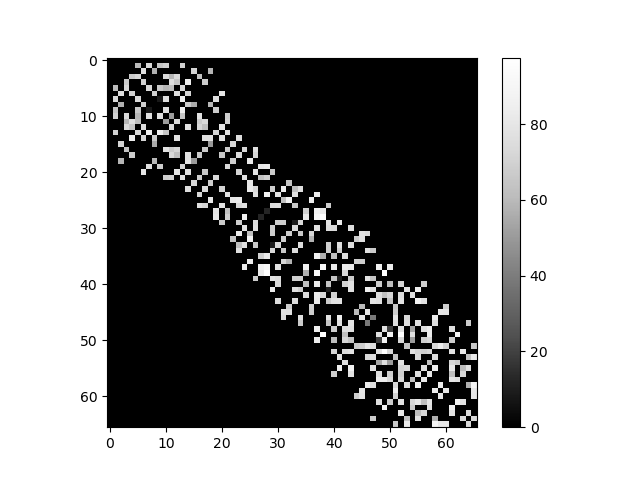
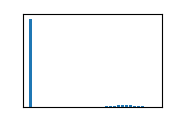

In [27]:
stddev_intensity_matrix

We can threshold this matrix to identify edges that have low standard deviation.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
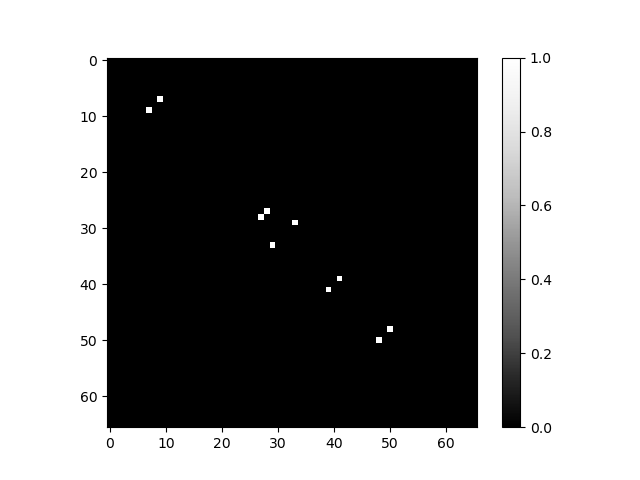
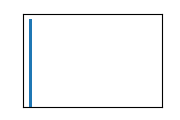

In [28]:
binary_matrix = cle.logical_and(stddev_intensity_matrix < 20, stddev_intensity_matrix > 0)  
binary_matrix

We can visualize this _mesh_ again in image space...

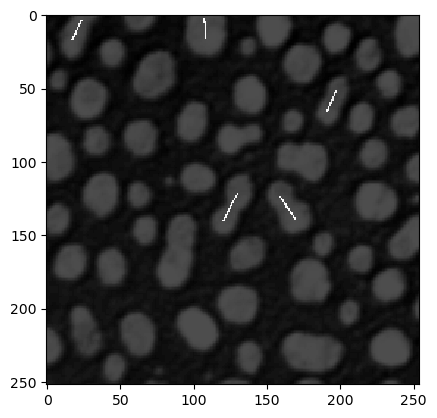

In [29]:
# draw the intensity mesh
binary_mesh = cle.touch_matrix_to_mesh(centroids, binary_matrix)

cle.imshow(blobs, continue_drawing=True)
cle.imshow(binary_mesh, alpha=0.7)

... and use it to merge labels.

cl.OCLArray([[ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
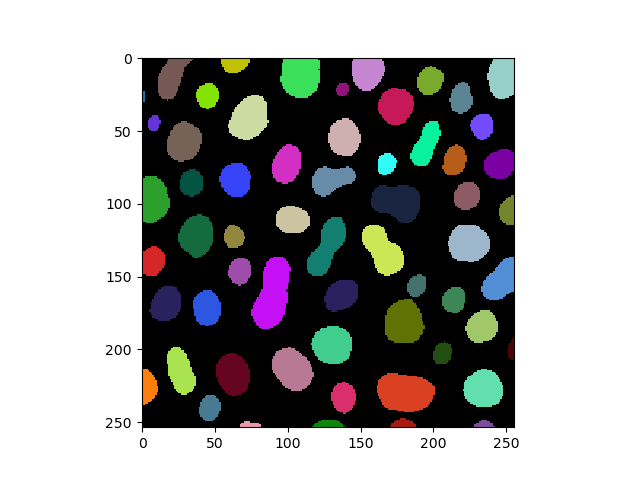

In [30]:
merged_labels = cle.merge_labels_according_to_touch_matrix(labels, binary_matrix)
merged_labels

## Merging touching labels
There are also short-cuts to similar functions such as for merging touching labels.

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
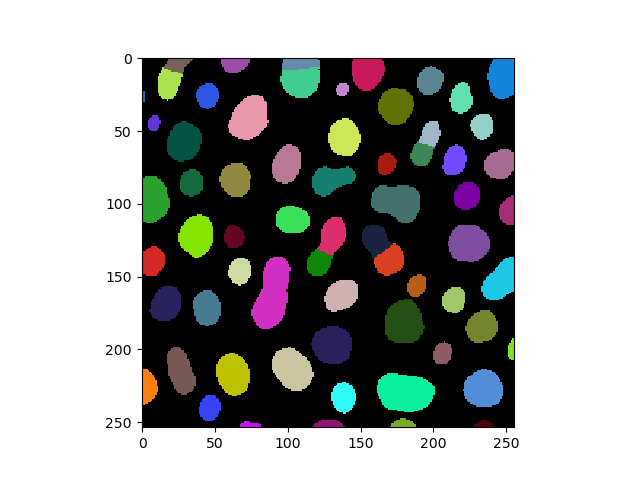

In [31]:
labels

cl.OCLArray([[ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
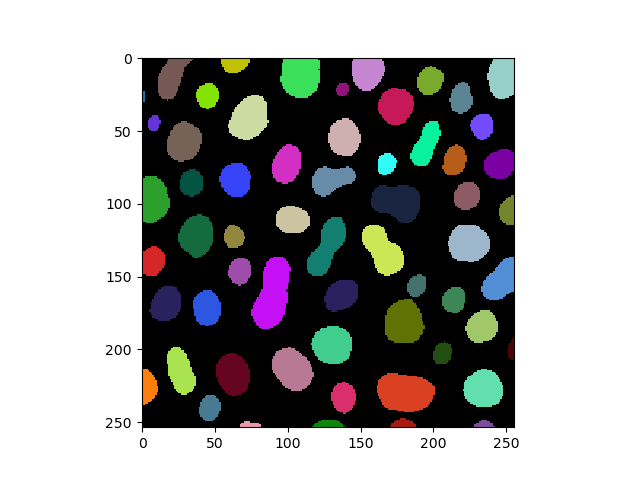

In [32]:
cle.merge_touching_labels(labels)

## Quantification of touching labels

When working with touching objects, one might be interested in how much things touch. The more labels touch, the larger the touch-portion. Touch portion is a value between 0 and 1. It describes how much of the outline of an object touches with other objects.


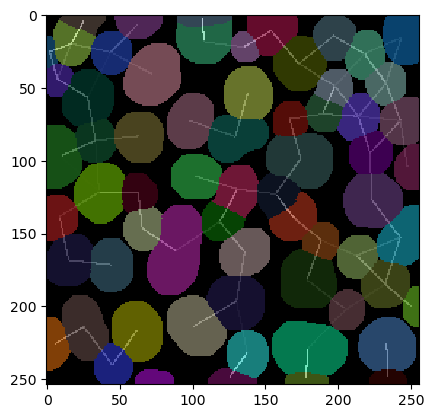

In [33]:
touch_portion_mesh = cle.draw_touch_portion_mesh_between_touching_labels(larger_labels)

cle.imshow(larger_labels, labels=True, continue_drawing=True)
cle.imshow(touch_portion_mesh, alpha=0.5)